In [37]:
# Analyze games and save evaluation for each move

In [421]:
import chess #https://github.com/niklasf/python-chess
from stockfish import Stockfish

#We'll create an intentionally worse stockfish engine to estimate complexity of positions
stockfish_good=Stockfish("C:/Users/aober/Documents/Data_Science_Studium/4Semester/BigData/stockfish/stockfish-windows-x86-64-avx2.exe")
stockfish_good.set_depth(10) 
stockfish_good.set_skill_level(10) 
import chess.pgn
import pandas as pd
pd.options.display.max_columns=999
import datetime
import tqdm
import zipfile
import numpy as np

In [446]:
file_name = "apendra_games"

In [447]:
games=pd.read_csv(f"../../testData/{file_name}.csv")

In [448]:
def safe_convert_to_int(value):
    try:
        return int(value)
    except ValueError:
        return None  # or you can use np.nan or a placeholder like -1

In [449]:
games['moves']=games['moves'].apply(lambda x: eval(x))
games['headers']=games['headers'].apply(lambda x: eval(x))#to dict

# Running Stored Game
All the functions down there, are used for the analysis.
get_accuracy(): is a simpel approach of calcualting the acccuracy of an opening
build_stored_game_analysis(): Is the evaluation of the game, the game is passed as a parameter an iterates over every move and uses the defined stockfish from the beginning of the document to evaluate the postion. In tis approach if the strongest version of stockfish is used, will be very slow.

In [430]:
#Standard point values for different pieces. Lowercase is white piece and uppercase is black
piece_scores={
    "p": 1,
    "P": -1,
    "r": 5,
    "R": -5,
    "n": 3,
    "N": -3,
    "b": 3,
    "B": -3,
    "q": 9,
    "Q": -9
}

In [431]:
def get_accuracy(evaluation_change):
    if (evaluation_change <= 25 and evaluation_change >= -25):
        return 100
    elif (evaluation_change > 25 and evaluation_change <= 50) or (evaluation_change < -25 and evaluation_change >= -50):
        return 75
    elif (evaluation_change > 50 and evaluation_change <= 75) or (evaluation_change < -50 and evaluation_change >= -75):
        return 50
    elif (evaluation_change > 75 and evaluation_change <= 100) or (evaluation_change < -75 and evaluation_change >= -100):
        return 25
    else:
        return 0


In [432]:
import random

#Used by chessnit.com
def build_stored_game_analysis(game, move_number, prev_evaluation):
    row={}
    row['move_number']=move_number
    row['taken']=[]
    board=chess.Board()
    for san in game['moves'][:move_number]:
        parsed_san=board.parse_san(san)
        taken=board.piece_at(parsed_san.to_square)
        if taken:
            row['taken'].append(taken.__str__())
        move=board.push_san(san)
    row['invalid']=bool(board.promoted) or bool(board.outcome())
    stockfish_good.set_fen_position(board.fen())
    evaluation=stockfish_good.get_evaluation()
    row['evaluation']=evaluation['value']
    row['evaluation_change']=evaluation['value']-prev_evaluation
    row['accuracy'] = get_accuracy(row['evaluation_change'])
    
    
    row['taken_score']=sum([piece_scores.get(p) for p in row['taken']])*100
    row['fen']=board.fen()
    row['url']=game['headers'].get("_tag_roster", {}).get("Site", "")+f"#{move_number}"
    try:
        row['last_move']=san
    except:
        print(game)
        row['invalid']=True
    return row, evaluation['value']


In [433]:

import pandas as pd
import tqdm

def analyze_games(games, n, max_move_number):
    all_game_analysis = []
    
    # Iterate over the first n games in the DataFrame
    prev_evaluation  = 0
    for i in tqdm.tqdm(range(min(n, len(games)))):
        game = games.iloc[i]
        game_analysis = []
        
        # Analyze each game up to the specified move number
        for move_number in range(1, max_move_number + 1):
            analysis_result, current_evaluation = build_stored_game_analysis(game, move_number,prev_evaluation)
            game_analysis.append(analysis_result)
            prev_evaluation = current_evaluation
        # Store the analysis results for each game
        all_game_analysis.append(pd.DataFrame(game_analysis).set_index("move_number"))
    
    return all_game_analysis


In [451]:

# Define the number of games and the maximum move number you want to analyze
n_games = 100  # For example, analyze the first 10 games
max_move_number = 10

# Assuming 'games' is your DataFrame containing the games
games_analysis = analyze_games(games, n_games, max_move_number)

# Now, games_analysis is a list of DataFrames, each containing the analysis of one game


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


# Aggregations and visualizations

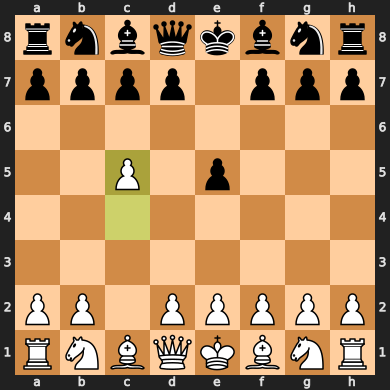

In [ ]:
#Visualizazion of given game
game=games.iloc[1]

move_number=3
row={}
row['taken']=[]
board=chess.Board()
for san in game['moves'][:move_number]:
    parsed_san=board.parse_san(san)#move by the san "Standard Algebraic Notation"
    taken=board.piece_at(parsed_san.to_square)
    if taken:
        row['taken'].append(taken.__str__())
    move=board.push_san(san)
board

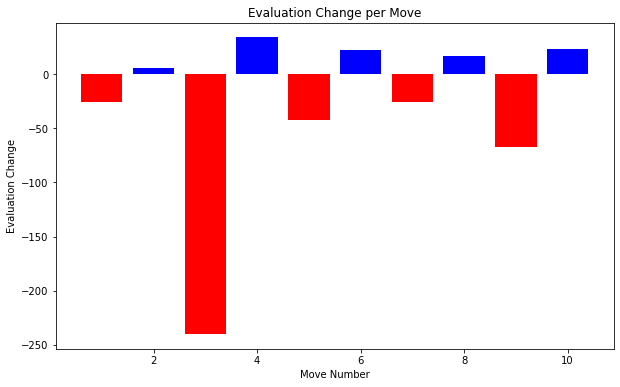

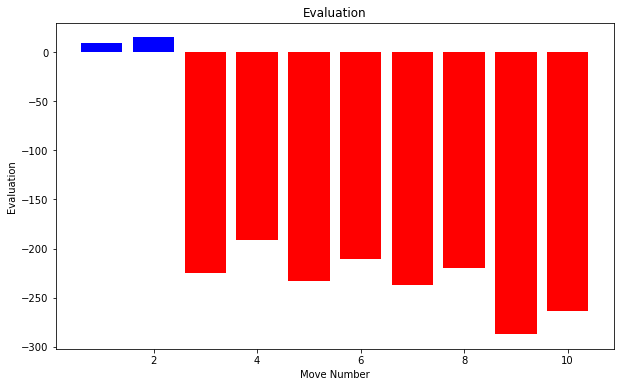

The largest change was -240 on move 3.
https://lichess.org/W4qIfyPj#3


In [ ]:
game_index = 1
df = pd.DataFrame(games_analysis[game_index]['evaluation_change'], columns=['evaluation_change'])
df2 = pd.DataFrame(games_analysis[game_index]['evaluation'], columns=['evaluation'])

import pandas as pd
import matplotlib.pyplot as plt

# Assuming games_analysis[0]['evaluation_change'] is a list or similar structure
df['move_number'] = range(1, len(df) + 1)
df2['move_number'] = range(1, len(df) + 1)

plt.figure(figsize=(10, 6))
plt.bar(df['move_number'], df['evaluation_change'], color=df['evaluation_change'].apply(lambda x: 'blue' if x >= 0 else 'red'))
plt.xlabel('Move Number')
plt.ylabel('Evaluation Change')
plt.title('Evaluation Change per Move')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(df2['move_number'], df2['evaluation'], color=df2['evaluation'].apply(lambda x: 'blue' if x >= 0 else 'red'))
plt.xlabel('Move Number')
plt.ylabel('Evaluation')
plt.title('Evaluation')
plt.show()

biggest_change = 0
move = 1

for index, change in enumerate(df['evaluation_change'], start=1):
    # Check if the absolute value of the change is larger than the biggest_change
    if abs(change) > abs(biggest_change):
        biggest_change = change
        move = index

print(f"The largest change was {biggest_change} on move {move}.")
print(games_analysis[game_index]['url'][move])
        

In [476]:
games_white = games[0:100][games['player_color'] == "White"]
agg_color_opening = games_white.groupby(['player_color', 'opening_name']).size().reset_index(name='count')
agg_color_opening_score = games_white.groupby(['opening_name', 'score']).size().reset_index(name='count')

games_black = games[0:100][games['player_color'] == "Black"]
agg_color_opening = games_black.groupby(['player_color', 'opening_name']).size().reset_index(name='count')
agg_color_opening_score = games_black.groupby(['opening_name', 'score']).size().reset_index(name='count')




C:\Users\aober\AppData\Local\Temp\ipykernel_1928\2530105734.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  games_white = games[0:100][games['player_color'] == "White"]
C:\Users\aober\AppData\Local\Temp\ipykernel_1928\2530105734.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  games_black = games[0:100][games['player_color'] == "Black"]


In [471]:
games_black

,headers,moves,lichess_id,white_elo,black_elo,ECO,opening_name,event,player_color,score
0,"{'_tag_roster': {'Event': 'Rated Bullet game',...","[e2e4, e7e5, g1f3, b8c6, f1b5, a7a6, b5c6, d7c...",https://lichess.org/R5xvWQmB,1393.0,1490.0,C68,"Ruy Lopez: Exchange Variation, Keres Variation",Rated Bullet game,Black,0.0
1,"{'_tag_roster': {'Event': 'Rated Bullet game',...","[c2c4, e7e5, c4c5, f8c5, g2g3, g8f6, f1g2, d7d...",https://lichess.org/W4qIfyPj,1468.0,1485.0,A20,English Opening: King's English Variation,Rated Bullet game,Black,1.0
3,"{'_tag_roster': {'Event': 'Rated Bullet game',...","[e2e4, e7e5, g1f3, b8c6, f1c4, f8c5, b2b4, c5b...",https://lichess.org/vBCaaIq2,1549.0,1484.0,C52,"Italian Game: Evans Gambit, Pierce Defense",Rated Bullet game,Black,1.0
6,"{'_tag_roster': {'Event': 'Rated Bullet game',...","[d2d4, f7f5, c1f4, g8f6, g1f3, e7e6, e2e3, b7b...",https://lichess.org/zGzfZ9ew,1474.0,1464.0,A80,Dutch Defense,Rated Bullet game,Black,1.0
9,"{'_tag_roster': {'Event': 'Rated Bullet game',...","[e2e4, e7e5, g1f3, b8c6, f1c4, f8c5, c2c3, g8f...",https://lichess.org/KEkOpdsl,1492.0,1483.0,C54,"Italian Game: Giuoco Piano, Greco's Attack",Rated Bullet game,Black,0.0
10,"{'_tag_roster': {'Event': 'Rated Bullet game',...","[d2d4, f7f5, c1f4, g8f6, e2e3, e7e6, g1f3, f8e...",https://lichess.org/nItMHMv2,1493.0,1489.0,A80,Dutch Defense,Rated Bullet game,Black,0.0
12,"{'_tag_roster': {'Event': 'Rated Bullet game',...","[e2e4, e7e5, f1c4, b8c6, d2d3, f8c5, c2c3, g8f...",https://lichess.org/t6kU1MF8,1469.0,1488.0,C23,Bishop's Opening,Rated Bullet game,Black,0.0
14,"{'_tag_roster': {'Event': 'Rated Bullet game',...","[d2d4, f7f5, c2c4, g8f6, b1c3, e7e6, e2e3, f8b...",https://lichess.org/BcoQdj3B,1397.0,1478.0,A85,Dutch Defense: Queen's Knight Variation,Rated Bullet game,Black,1.0
17,"{'_tag_roster': {'Event': 'Rated Bullet game',...","[d2d3, e7e5, e2e4, b8c6, g1f3, f8c5, f1e2, g8f...",https://lichess.org/KuRI2yIi,1473.0,1473.0,C20,King's Pawn Game: Leonardis Variation,Rated Bullet game,Black,0.0
18,"{'_tag_roster': {'Event': 'Rated Bullet game',...","[e2e4, e7e5, f2f4, e5f4, d2d4, g7g5, g1f3, f8e...",https://lichess.org/eT7BiAGe,1449.0,1467.0,C37,King's Gambit Accepted: Rosentreter Gambit,Rated Bullet game,Black,1.0


In [477]:
#Plot accuracy per opening

#WHITE
index_white = games_white.index.tolist()
games_analysis10 = [games_analysis[i] for i in index_white]
games_white['average_accuracy'] = [np.mean(games_analysis10[i]["accuracy"]) for i in range(len(games_analysis10))]
# Now group by opening_name and calculate the mean of average_accuracy
agg_accuracy_opening = games_white.groupby('opening_name')['average_accuracy'].mean().reset_index(name='mean_accuracy')
# If you need to include the count of games per opening as well:
agg_accuracy_opening['count'] = games_white.groupby('opening_name').size().reset_index(name='count')['count']


#BLACK
index_black = games_black.index.tolist()
games_analysis_black = [games_analysis[i] for i in index_black]
games_black['average_accuracy'] = [np.mean(games_analysis_black[i]["accuracy"]) for i in range(len(games_analysis_black))]
# Now group by opening_name and calculate the mean of average_accuracy
agg_accuracy_opening_black = games_black.groupby('opening_name')['average_accuracy'].mean().reset_index(name='mean_accuracy')
agg_accuracy_opening_black['count'] = games_black.groupby('opening_name').size().reset_index(name='count')['count']



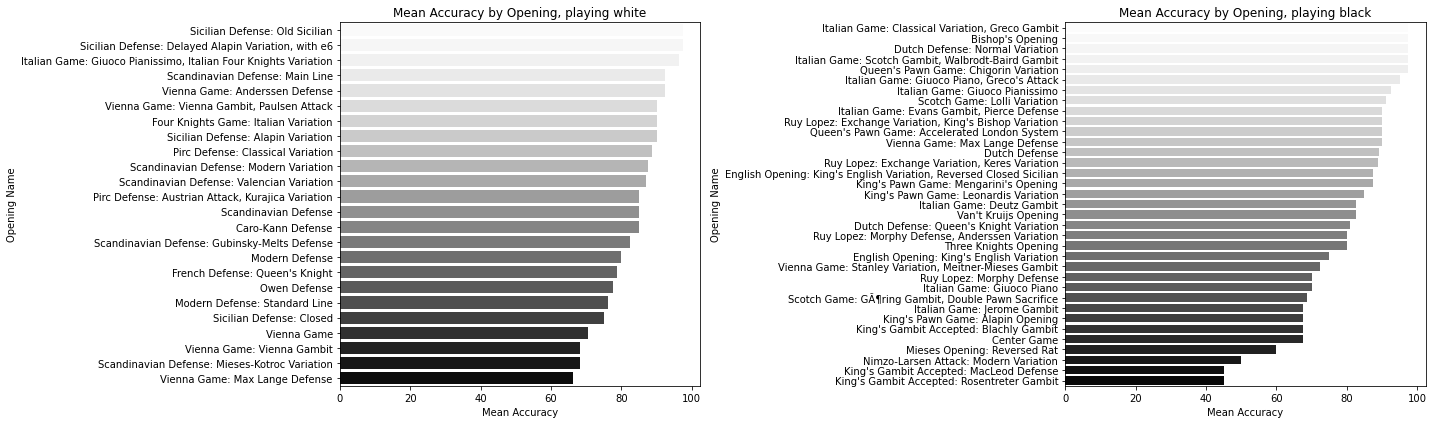

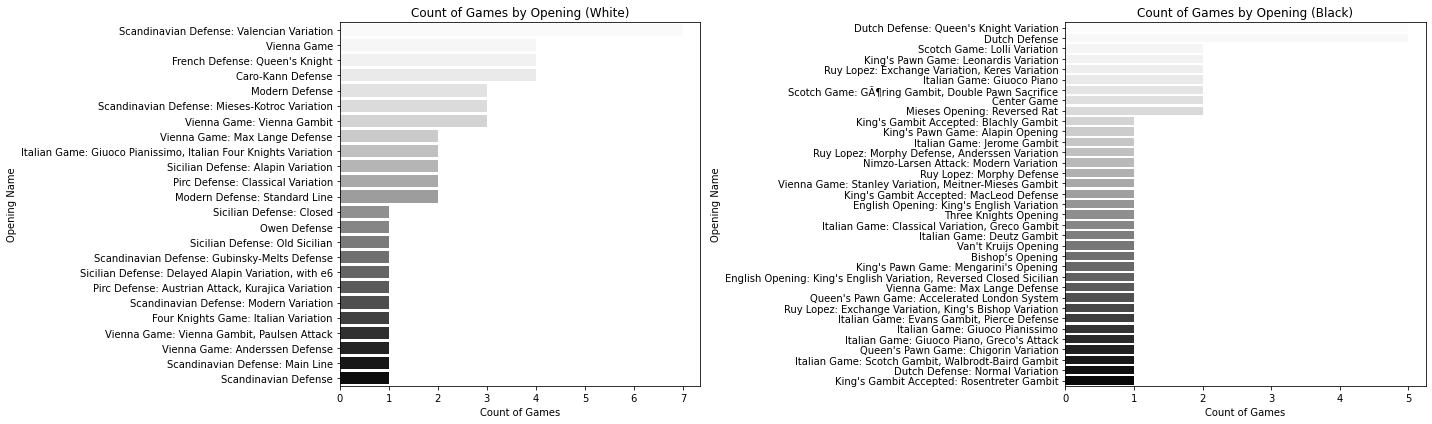

In [483]:

#PLOTS WHITE

agg_accuracy_opening = agg_accuracy_opening.sort_values('mean_accuracy', ascending=False)
agg_accuracy_opening_black = agg_accuracy_opening_black.sort_values('mean_accuracy', ascending=False)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

sns.barplot(x='mean_accuracy', y='opening_name', data=agg_accuracy_opening, palette='Greys', ax=ax1)
ax1.set_title('Mean Accuracy by Opening, playing white')
ax1.set_xlabel('Mean Accuracy')
ax1.set_ylabel('Opening Name')

black_palette = sns.light_palette("black", reverse=True, as_cmap=False)
sns.barplot(x='mean_accuracy', y='opening_name', data=agg_accuracy_opening_black, palette='Greys', ax=ax2)
ax2.set_title('Mean Accuracy by Opening, playing black')
ax2.set_xlabel('Mean Accuracy')
ax2.set_ylabel('Opening Name')

plt.tight_layout()
plt.show()


agg_accuracy_opening = agg_accuracy_opening.sort_values('count', ascending=False)
agg_accuracy_opening_black = agg_accuracy_opening_black.sort_values('count', ascending=False)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot for white
sns.barplot(x='count', y='opening_name', data=agg_accuracy_opening, palette='Greys', ax=ax1)
ax1.set_title('Count of Games by Opening (White)')
ax1.set_xlabel('Count of Games')
ax1.set_ylabel('Opening Name')

# Plot for black
sns.barplot(x='count', y='opening_name', data=agg_accuracy_opening_black, palette='Greys', ax=ax2)
ax2.set_title('Count of Games by Opening (Black)')
ax2.set_xlabel('Count of Games')
ax2.set_ylabel('Opening Name')

plt.tight_layout()
plt.show()
